In [86]:
from qick import *
from qick.averager_program import *
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [87]:
soc = QickSoc()
soccfg = soc
print(soccfg)


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v4 - tProc out

In [88]:
class SingleToneSpectroscopyProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg 
        self.declare_gen(ch=cfg["qubit_ch"], nqz=1)
        
        for ch in [1]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["qubit_ch"])
            
        global freq
        freq = self.freq2reg(cfg["f_res"], gen_ch=cfg["qubit_ch"], ro_ch=1)
        
        self.add_DRAG(ch=cfg["qubit_ch"], name="drive", length=cfg["qubit_length"], sigma=cfg["qubit_length"]/4,
                      delta=cfg["delta"], alpha=cfg["alpha"])
        
        self.add_gauss(ch=cfg["qubit_ch"], name="gauss", sigma=cfg["res_sigma"]/4, length=cfg["res_sigma"])
        
        step=200
        width=280
        willis=np.concatenate((np.ones(4*width)*27*step, np.ones(1*width)*45*step, np.ones(48)*55*step, np.ones(2*width)*45*step,
                               np.ones(48)*55*step, np.ones(3*width)*45*step, np.ones(6*width)*35*step, np.ones(4*width)*27*step))
        
        self.add_pulse(ch=cfg["qubit_ch"], name="willis", idata=willis)
        self.add_pulse(ch=cfg["qubit_ch"], name="test", idata=np.ones(6400)*32766)
            
        
        self.synci(200)
    
    def body(self):
        cfg=self.cfg
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=cfg["adc_trig_offset"])
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", waveform="willis", freq=freq, 
                                 phase=self.deg2reg(cfg["phase"]), gain=cfg["gain"])
        
        self.pulse(ch=cfg["qubit_ch"])
        
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [89]:
readout_cfg={
    "readout_length":1000, # [Clock ticks]
    "res_length":soccfg.us2cycles(1.0, gen_ch=0),
    "f_res":1000, # [MHz]
    "res_phase": 0,
    "adc_trig_offset":0, # [Clock ticks]
    "res_gain":1890,
    "drive_ro_delay":soccfg.us2cycles(0.05, gen_ch=0),
    "res_sigma":soccfg.us2cycles(3.0, gen_ch=0),
    "delta":200,
    "alpha":0,
    "qubit_length":soccfg.us2cycles(1, gen_ch=0),
    "qubit_ch":0,
    "res_ch":5
    }

<IPython.core.display.Javascript object>


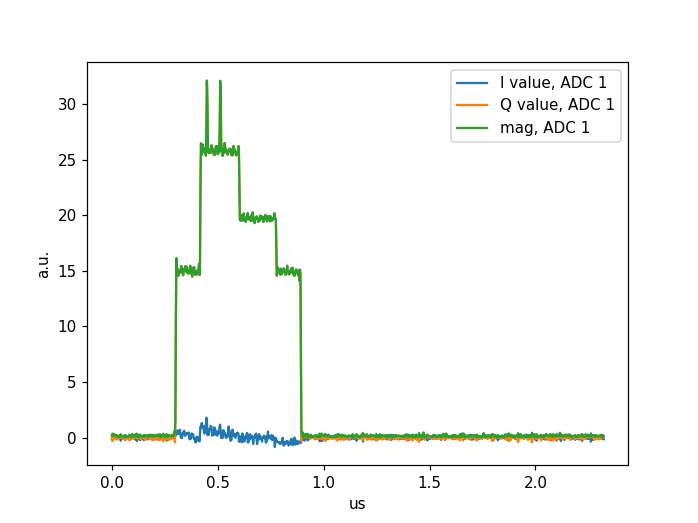

In [85]:
expt_cfg={"reps":1, "relax_delay":10, "gain":30000, "soft_avgs":100}

config={**readout_cfg,**expt_cfg}

config["phase"]=246
rspec=SingleToneSpectroscopyProgram(soccfg, config)
iq_list=rspec.acquire_decimated(soc, load_pulses=True, progress=False)

plt.figure(1)
for ii, iq in enumerate(iq_list):
    time = np.arange(config["readout_length"])*soccfg.cycles2us(1)
    plt.plot(time, iq[0], label="I value, ADC 1")
    plt.plot(time, iq[1], label="Q value, ADC 1")
    plt.plot(time, np.abs(iq[0]+1j*iq[1]), label="mag, ADC 1")
plt.ylabel("a.u.")
plt.xlabel("us")
plt.legend()